# Compare warm and cold state in FOCI-OpenIFS

We are analysing the simulation FOCI_GJK001 performed on HLRN-Gottingen, late 2021. 
Tco95L91 + ORCA05L46

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cmocean 
import cartopy.feature as cfeature
import string
from scipy.stats import ttest_ind

In [2]:
from dask.distributed import Client, LocalCluster, wait

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:39635 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


In [5]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

## Read grid info

In [6]:
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_volume = (ds_mesh['e1t'] * ds_mesh['e2t'] * ds_mesh['e3t']).sel(t=0).rename({'z':'deptht'})
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)
da_orca05_mask_3D = ds_mesh['tmask'].sel(t=0).rename({'z':'deptht'})

## Read OpenIFS data

In [9]:
exp_list = ['FOCI_GJK001', 'FOCI_GJK001']
label_list = ['Warm phase','Cold phase']
time_list = [slice('2200-01-01','2400-01-01'), slice('2600-01-01','2800-01-01')]

In [8]:
# OpenIFS surface
ds_sfc_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc


In [27]:
def welch_ttest(x, y):
    t, p = ttest_ind(x, y, equal_var=False)
    return p

## Surface state

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/ipykernel_launcher.py:102: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


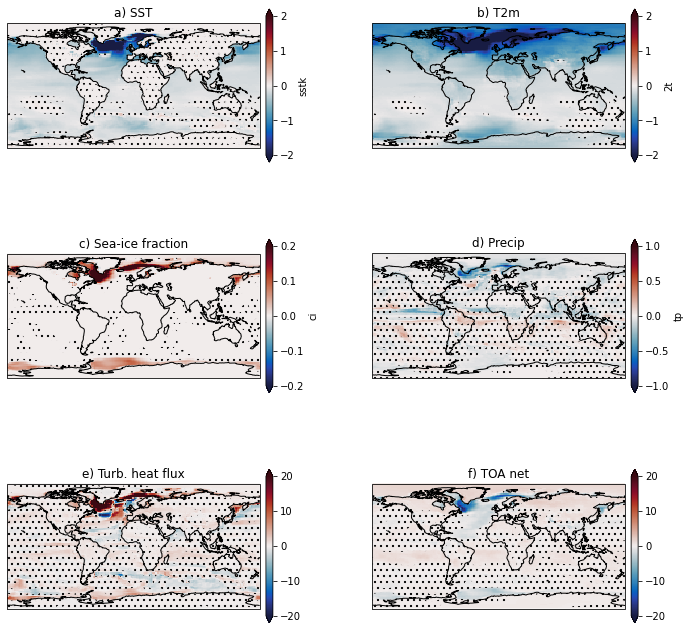

In [41]:
# Plot settings
prj = ccrs.PlateCarree()

cmap = cmocean.cm.balance

# Set up plot
fig1, axs1 = plt.subplots(3,2,figsize=(12,12),subplot_kw={'projection':prj})
ax1 = axs1.flat

i1 = 1
i2 = 0
label = '%s - %s' % (label_list[i1],label_list[i2])

letters = string.ascii_lowercase

variables = ['sstk','2t','ci','tp','ssf','toa']
for i,v in enumerate(variables): 
    
    scale = 1
    if v == 'sstk':
        vv = 'SST'
        vmax = 2
        
    elif v == '2t':
        vv = 'T2m'
        vmax = 2
    
    elif v == 'ci':
        vv = 'Sea-ice fraction'
        vmax = 0.2
        
    elif v == 'tp':
        scale = 4000 # mm/d
        vv = 'Precip'
        vmax = 1
    
    elif v == 'msl':
        scale = 0.01
        vv = 'MSLP'
        vmax = 1
    
    elif v == 'ssf':
        scale = 1./(6 * 60 * 60)
        vv = 'Turb. heat flux'
        vmax = 20
        
    elif v == 'toa':
        scale = 1./(6 * 60 * 60)
        vv = 'TOA net'
        vmax = 20
    
    if v == 'ssf':
        data1_1 = ds_sfc_all[i1]['sshf'].groupby('time.year').mean('time').compute() * scale
        data1_2 = ds_sfc_all[i1]['slhf'].groupby('time.year').mean('time').compute() * scale
        
        data2_1 = ds_sfc_all[i2]['sshf'].groupby('time.year').mean('time').compute() * scale
        data2_2 = ds_sfc_all[i2]['slhf'].groupby('time.year').mean('time').compute() * scale
        
        data1 = data1_1 + data1_2
        data2 = data2_1 + data2_2
        
    elif v == 'toa':
        data1_1 = ds_sfc_all[i1]['tsr'].groupby('time.year').mean('time').compute() * scale
        data1_2 = ds_sfc_all[i1]['ttr'].groupby('time.year').mean('time').compute() * scale
        
        data2_1 = ds_sfc_all[i2]['tsr'].groupby('time.year').mean('time').compute() * scale
        data2_2 = ds_sfc_all[i2]['ttr'].groupby('time.year').mean('time').compute() * scale
        
        data1 = data1_1 + data1_2
        data2 = data2_1 + data2_2
        
    else:
        data1 = ds_sfc_all[i1][v].groupby('time.year').mean('time').compute() * scale
        data2 = ds_sfc_all[i2][v].groupby('time.year').mean('time').compute() * scale
        
    mean_diff = data1.mean('year') - data2.mean('year')
    
    # Welch T-test
    # Probability that two sets of annual means have same mean (not assuming same variance)
    # First make data2 with same time axis so that xarray does not complain
    _data2 = data2.copy()
    _data2['year'] = data1['year']
    pval  = xr.apply_ufunc(welch_ttest,
                           data1, _data2,
                           vectorize=True, dask='parallelized',
                           input_core_dims=[['year'], ['year']],
                           output_dtypes=['d']).compute()
    
    ckw = {'shrink':0.8, 'pad':0.02, 'extend':'both'} #, 'label':'SST [K]'}
    mean_diff.plot(ax=ax1[i],cmap=cmap,vmin=-vmax,vmax=vmax,cbar_kwargs=ckw,rasterized=True)
    
    # Plot dots where probability > 5%
    pval.plot.contourf(ax=ax1[i],levels=(0, 0.05,1.), transform=ccrs.PlateCarree(),
                       colors='none', hatches=(None, '..'),
                       add_colorbar=False)
    
    ax1[i].set_title('%s) %s' % (letters[i],vv))
    
for ax in ax1:
    ax.coastlines()

fig1.tight_layout()
fig1.savefig('Fig5_warm_vs_cold.pdf',format='pdf')